In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
from pathlib import Path
import random
from copy import deepcopy
import datetime
import hydra
from omegaconf import DictConfig, OmegaConf
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import IPython.display as ipd
from data import YOLODataset, Subset, collate_fn, get_binary_f1
from modules import YOLO, nms, classwise_nms, get_iou, grid_to_absolute, CNNModel
import constants as C

In [10]:
load_checkpoint = Path("checkpoints/YOLO/reduce_none_sample_best_epoch34_1.6842.pt")
# load_checkpoint = Path("checkpoints/YOLO/merged-version-base24-do0.4-no_none_pitch0.3_best_epoch111_1.3277.pt")
base_hidden = 24
use_merged_data = False
split = "version"

baseline_checkpoint = Path("checkpoints/CNN/baseline_base16_do0.2_version_best_epoch33_0.0241.pt")

In [8]:
yolo_thresholds = [
    (0.50, 0.35),
    (0.55, 0.40),
    (0.50, 0.65),
    (0.45, 0.40),
    (0.35, 0.30),
    (0.60, 0.60),
    (0.55, 0.30),
    (0.50, 0.30),
    (0.55, 0.30),
    (0.60, 0.45),
    (0.60, 0.50),
    (0.55, 0.45),
    (0.65, 0.50)
]

In [13]:
with hydra.initialize(version_base=None, config_path="config"):
    cfg = hydra.compose(config_name="yolo_config")

DEV = "cuda:1" if torch.cuda.is_available() else "cpu"
random.seed(cfg.random_seed)
torch.manual_seed(cfg.random_seed)

base_set = YOLODataset(
    Path(cfg.dataset.wav_dir), 
    Path(cfg.dataset.instances_dir),
    C.TRAIN_VERSIONS,
    C.VALID_VERSIONS,
    C.TRAIN_ACTS,
    C.VALID_ACTS,
    C.MOTIFS,
    C.ANCHORS,
    test_versions=C.TEST_VERSIONS,
    test_acts=C.TEST_ACTS,
    use_merged_data=use_merged_data,
    overlap_sec = 0,
    include_threshold = 0.5,
    split = split,
    mixup_prob = 0,
    mixup_alpha = 0,
    pitchshift_prob = 0,
    pitchshift_semitones = 0,
    eval=True,
    device = DEV
)

test_set = None
if cfg.dataset.split == "version":
    test_set = Subset(base_set, base_set.get_subset_idxs(versions=C.TEST_VERSIONS), 0)
elif cfg.dataset.split == "act":
    test_set = Subset(base_set, base_set.get_subset_idxs(acts=C.TEST_ACTS), 0)
else:
    raise ValueError("Invalid split method")

model = YOLO(
    num_anchors=len(C.ANCHORS),
    C=len(C.MOTIFS),
    base_hidden=16,
    dropout=0.2
)
model.to(DEV)
model.eval()
ckpt = torch.load(load_checkpoint, weights_only=True)
model.load_state_dict(ckpt["model"])

baseline = CNNModel(
    num_classes=len(C.MOTIFS) + 1,
    base_hidden=16,
    dropout=0.2
)
baseline.to(DEV)
baseline.eval()
baseline_ckpt = torch.load(baseline_checkpoint, weights_only=True)
baseline.load_state_dict(baseline_ckpt["model"])

Loading data...


  0%|          | 0/143 [00:00<?, ?it/s]

Shuffling and truncating none samples...
CQT kernels created, time used = 0.0243 seconds
CQT kernels created, time used = 0.0255 seconds


<All keys matched successfully>

In [111]:
def visualize(idx, yolo_thresholds):
    wav, gt, framewise_gt = test_set[idx]
    gt = gt.clone()
    with torch.inference_mode():
        wav = wav.unsqueeze(0).to(DEV)
        cqt = model.transform(wav).cpu()
        pred = model(wav)
        baseline_pred = baseline(wav)[:, :, :-1].cpu()

    pred_boxes = classwise_nms(pred, torch.tensor(C.ANCHORS).to(DEV), yolo_thresholds)[0]
    gt[..., 1:2] = grid_to_absolute(gt[..., 1:2], batched=False)
    gt[..., 2:3] = gt[..., 2:3] * torch.tensor(C.ANCHORS).reshape(3, 1, 1)
    gt_boxes = gt[gt[..., 0] > 0].tolist()

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(20, 15), dpi=300, gridspec_kw={'height_ratios': [1, 2, 2, 3]})
    im = ax1.imshow(cqt[0], origin="lower", aspect="auto", cmap="magma", norm="log", vmin=0.01)

    print("GT:")
    for box in gt_boxes:
        ax2.imshow(torch.zeros((88, 646)), origin="lower", aspect="auto", cmap="magma")
        print(f" {box}")
        x = (box[1] - (box[2] / 2)) * 646
        y = 0
        w = box[2] * 646
        h = random.randint(10, 80)
        rect = patches.Rectangle((x, y), w, h, linewidth=4, edgecolor='g', facecolor='none')
        ax2.add_patch(rect)
        ax2.annotate(
            C.MOTIFS[int(box[3])], 
            (x+2, y+1), 
            color="white", 
            bbox= dict(boxstyle="square", fc="g", ec="g"),
            fontsize=12)
        
    print("Pred:")
    for box in pred_boxes: 
        ax3.imshow(torch.ones((88, 646)), origin="lower", aspect="auto", cmap="binary")
        print(f" {box}")
        x = (box[1] - (box[2] / 2)) * 646
        y = 0
        w = box[2] * 646
        # h = random.randint(10, 80)
        h = 90 * (box[0] - 0.4) * 1 / 0.6
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='black', facecolor='none')
        ax3.add_patch(rect)
        ax3.annotate(
            f"{C.MOTIFS[int(box[3])]}: {box[0]:.2f}", 
            (max(0,x+2), h), 
            color="white", 
            bbox= dict(boxstyle="square", fc="black", ec="black"),
            fontsize=13)
        
    ax4.imshow((baseline_pred.T > 0.5), origin="upper", aspect="auto", interpolation="none", cmap="binary")
    ax4.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
    ax4.set_yticks(range(13))
    ax4.set_yticklabels(C.MOTIFS)
    ax4.tick_params(axis="y", which="minor", length=0)
    ax4.grid(axis="y", which="minor")

    ipd.display(ipd.Audio(wav[0].cpu(), rate=22050))
    plt.show()

In [35]:
len(test_set)

164

GT:
 [1.0, 0.12833333015441895, 0.15533332526683807, 8.0]
 [1.0, 0.30043333768844604, 0.18859998881816864, 8.0]
 [1.0, 0.4760666787624359, 0.16226667165756226, 8.0]
 [1.0, 0.6409666538238525, 0.16726665198802948, 8.0]
 [1.0, 0.8122999668121338, 0.17499999701976776, 8.0]
 [1.0, 0.949999988079071, 0.10000000149011612, 8.0]
Pred:
 [0.9205656051635742, 0.1376807540655136, 0.17184782028198242, 8.0]
 [0.8886810541152954, 0.30803734064102173, 0.1700235903263092, 8.0]
 [0.8775126934051514, 0.486839234828949, 0.15570811927318573, 8.0]
 [0.8769620656967163, 0.9552358388900757, 0.10012935101985931, 8.0]
 [0.8587550520896912, 0.8305625319480896, 0.13396674394607544, 8.0]
 [0.8150456547737122, 0.7787024974822998, 0.15146751701831818, 8.0]
 [0.5914813876152039, 0.62181556224823, 0.15801012516021729, 8.0]


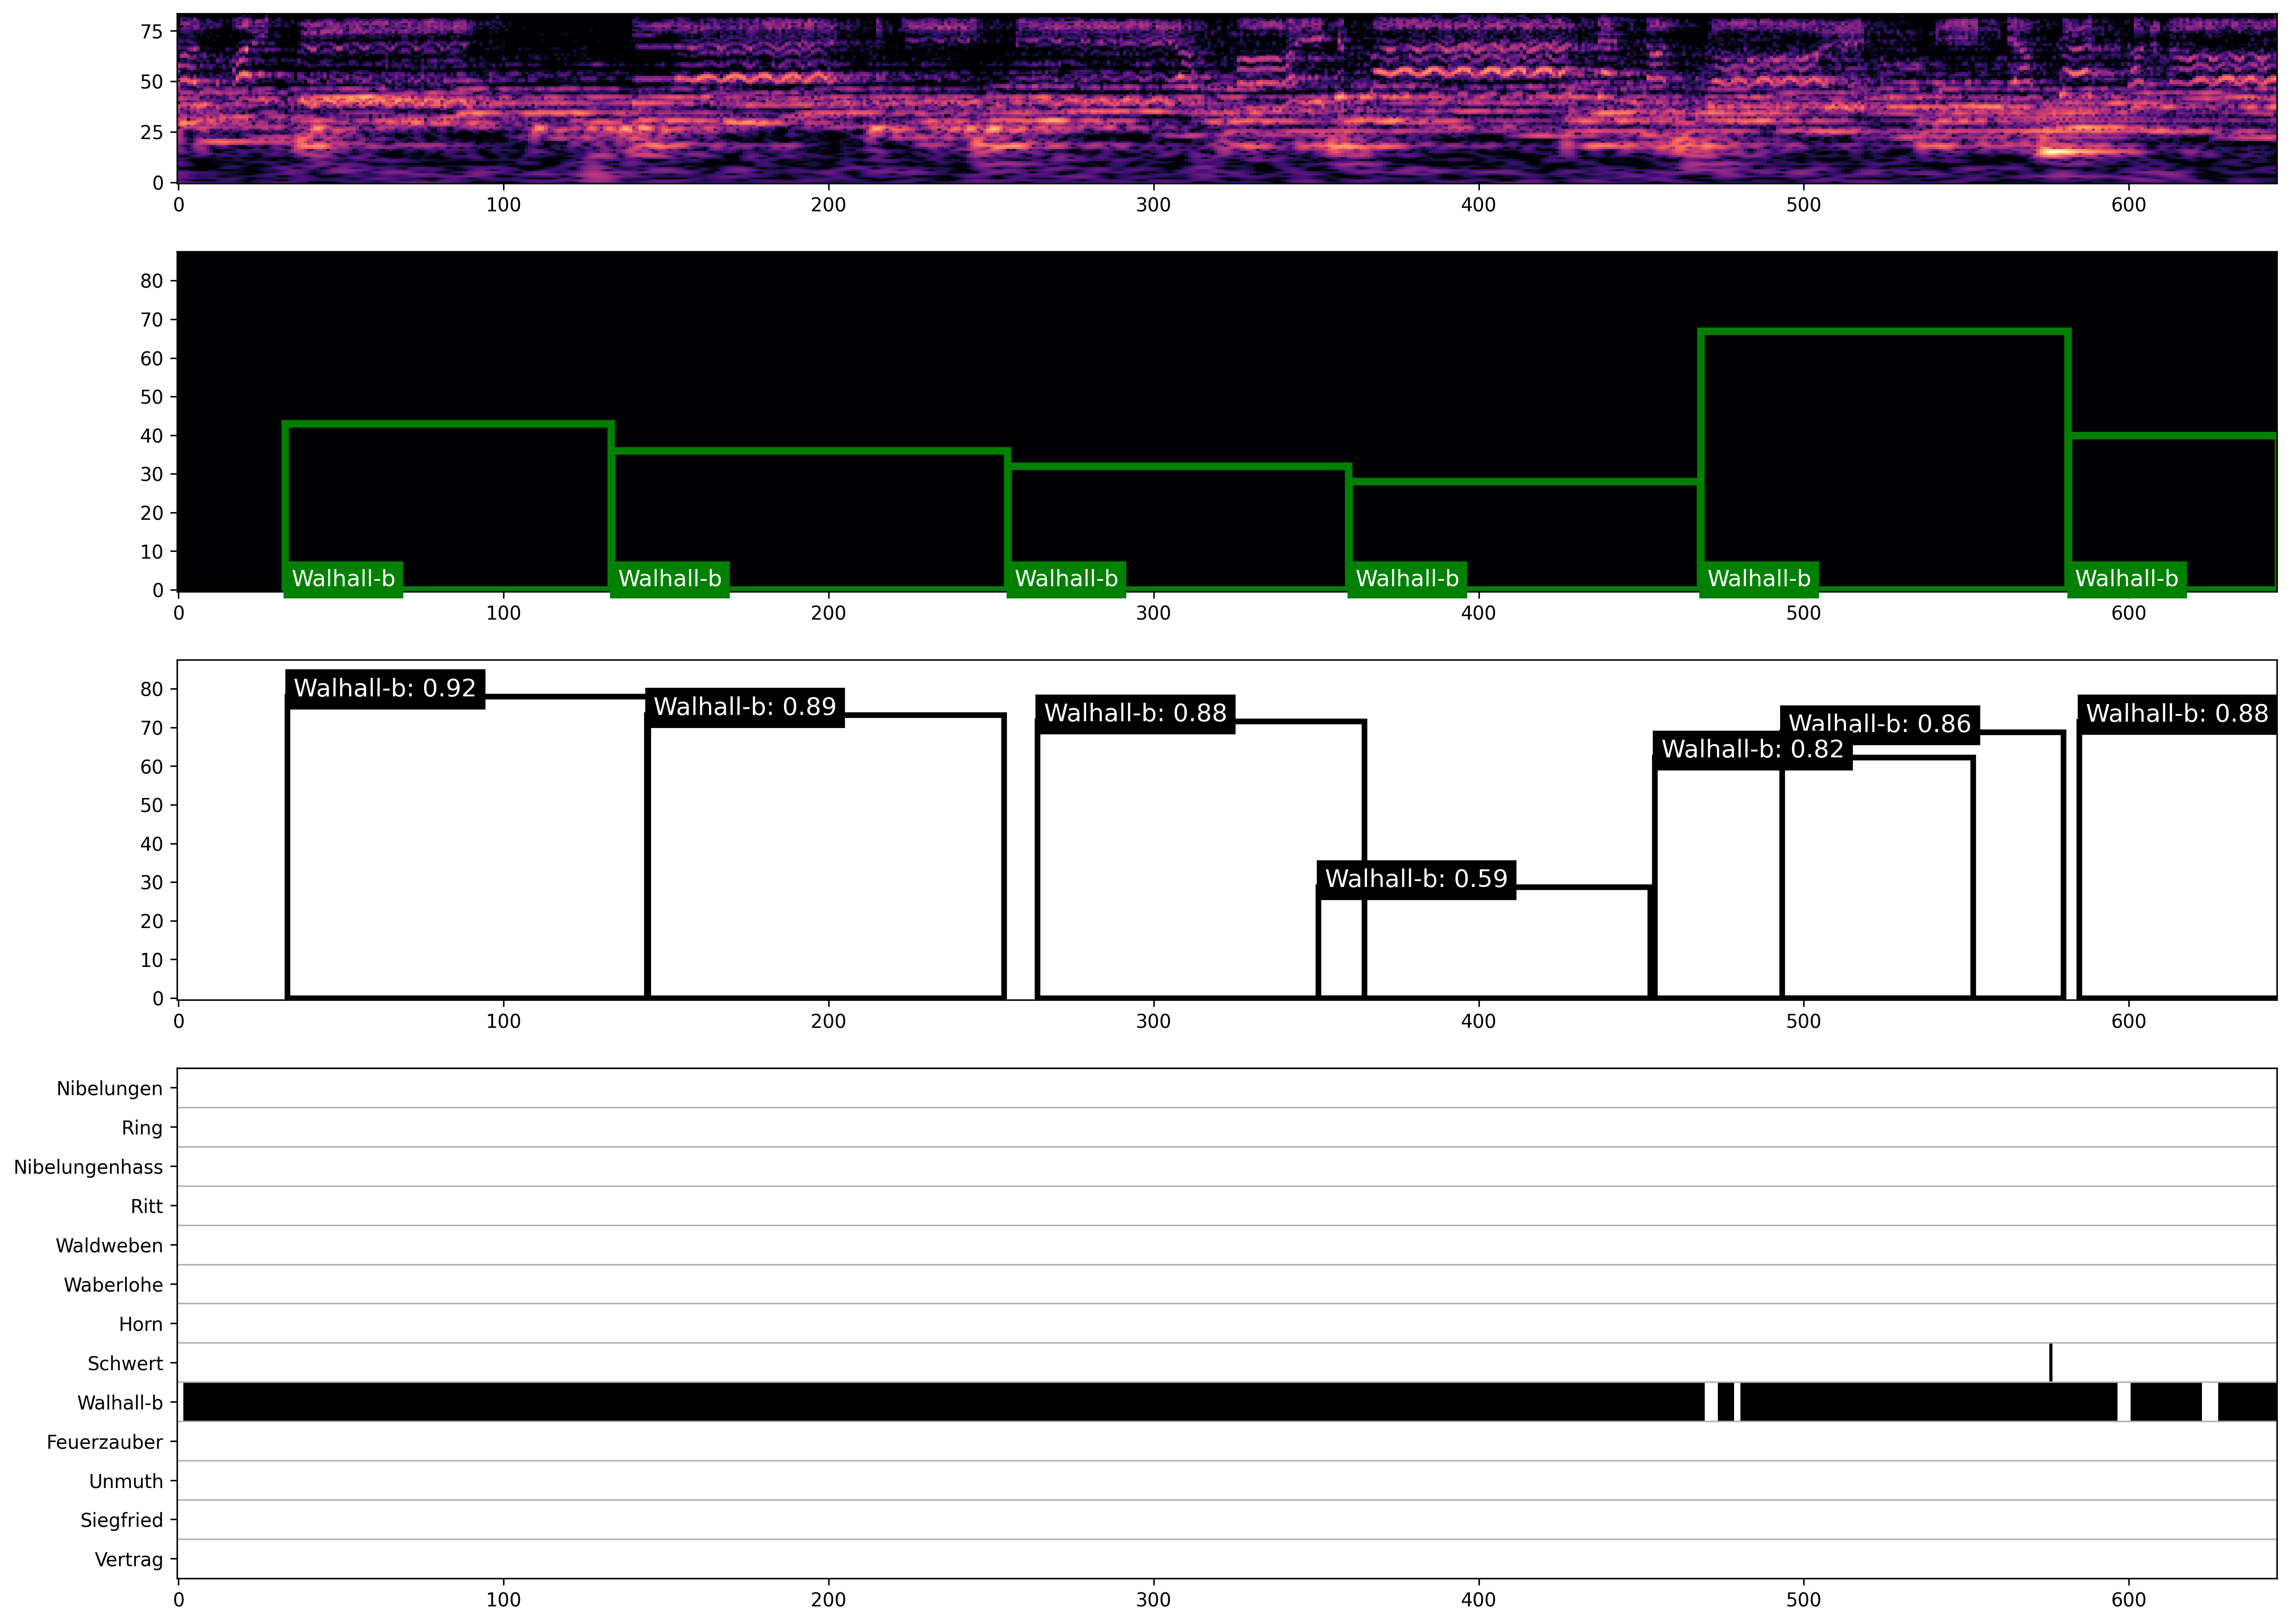

In [112]:
visualize(59, yolo_thresholds)

In [17]:
gt = test_set[285][1]
gt[:, :, 3]

tensor([[0., 3., 0., 3., 3., 0., 3., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])